In [331]:
pat = pd.read_csv('../data/interm/patients_2016.csv')
appt = pd.read_csv('../data/interm/appt_2016.csv')

### Prep data for modelling

In [332]:
pat.head()

,PatNum,LName,FName,PatStatus,Gender,Position,Birthdate,City,State,Zip,HmPhone,WkPhone,WirelessPhone,Guarantor,Email,EstBalance,PriProv,SecProv,BillingType,Bal_0_30,Bal_31_60,Bal_61_90,BalOver90,InsEst,BalTotal,EmployerNum,DateFirstVisit,HasIns,PreferContactMethod,fullname
0,8491,Coates,Paula,0,1,1,1944-11-19,Redding,CA,96003,(209)825-8925,NaN,NaN,8103,NaN,161.0,7,0,352,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-08-10,I,2,paula coates
1,8494,Daumont,Cyril,0,0,1,1981-10-22,Redding,CA,96003,NaN,NaN,(530)782-8221,6881,melissa.daumont512@gmail.com,158.4,7,0,352,0.0,0.0,0.0,0.0,0.0,0.0,934,2020-08-19,I,4,cyril daumont
2,8495,Zahniser,Tate,0,0,2,2010-11-18,Bella Vista,CA,96008,(530)310-2166,NaN,(530)310-5212,8270,NaN,45.0,1,0,352,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-09-02,I,4,tate zahniser
3,8496,Dennis,McKenna,0,1,2,2017-05-18,REDDING,CA,96003,NaN,NaN,(530)262-8400,6528,NaN,10.0,1,0,352,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-09-08,I,4,mckenna dennis
4,8497,Hurst,Landon,0,0,2,2006-04-12,REDDING,CA,96003,NaN,NaN,(530)262-8400,6528,Marcidennis@gmail.com,15.0,1,0,352,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-09-08,I,4,landon hurst


In [333]:
#drop uneeded columns
pat.drop(['LName', 'FName', 'City', 'State', 'BillingType', 'WkPhone', 'PriProv', 'SecProv', 'EmployerNum', 'Email', 'PreferContactMethod', 'Position', 'fullname'], axis=1, inplace=True)

In [334]:
pat['HmPhone'] = pat['HmPhone'].str[:4].str.replace('(','')
pat['WirelessPhone'] = pat['WirelessPhone'].str[:4].str.replace('(', '')

In [335]:
#create binary column for Area Code 530
pat['HmPhone'] = np.where(pat['HmPhone'] == '530', 1, 0)
pat['WirelessPhone'] = np.where(pat['WirelessPhone'] == '530', 1, 0)
pat.rename(columns={'HmPhone':'530_AreaCode'}, inplace=True)

In [336]:
pat['530_AreaCode'] = pat['530_AreaCode'] + pat['WirelessPhone']
pat['530_AreaCode'].value_counts()

1    1423
2     630
0     361
Name: 530_AreaCode, dtype: int64

In [337]:
pat.loc[:, '530_AreaCode'][pat['530_AreaCode'] == 2] = 1

<ipython-input-337-4e969ab539d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pat.loc[:, '530_AreaCode'][pat['530_AreaCode'] == 2] = 1


In [338]:
pat.drop('WirelessPhone', axis=1, inplace=True)
pat['530_AreaCode'].value_counts()

1    2053
0     361
Name: 530_AreaCode, dtype: int64

In [339]:
#strip Zip Code to 5 digits
pat['Zip'] = pat.Zip.str[:5]

In [340]:
#remove incorrect birthdates
pat['Birthdate'] = np.where(pat['Birthdate'] == '0001-01-01', np.nan, pat['Birthdate'])

In [341]:
pat['Birthdate'] = pd.to_datetime(pat['Birthdate'])

In [342]:
from datetime import datetime

In [343]:
#create age column
now = pd.to_datetime('now')
pat['age'] = (now - pat['Birthdate']).astype('<m8[Y]')

In [344]:
#fill age na values with mean age
pat.age.fillna(pat.age.mean(), inplace=True)

In [345]:
pat.drop('Birthdate', axis=1, inplace=True)

In [346]:
inactive = pat[pat['PatStatus'] == 2]['PatNum'].tolist()

In [347]:
appt['AptDate'] = pd.to_datetime(appt['AptDate'])

In [348]:
inac_appts = appt[appt['PatNum'].isin(inactive)]

In [349]:
pat['PatStatus'].value_counts()

0    1894
2     508
3      12
Name: PatStatus, dtype: int64

In [350]:
nonpatient = pat[pat['PatStatus'] == 1]['PatNum'].tolist()

In [351]:
nonp_index = appt[appt['PatNum'].isin(nonpatient)]['AptDate'].index

In [352]:
appt.drop(nonp_index, inplace=True)

In [353]:
#remove all non patients from patient and appointments tables 
pat = pat[pat['PatStatus'] != 3]
pat = pat[pat['PatStatus'] != 1]

In [354]:
pat.HasIns.value_counts()

I    1815
Name: HasIns, dtype: int64

In [355]:
pat['HasIns'] = np.where(pat['HasIns'] == 'I', 1, 0)

In [395]:
#create data for 2016 and newer
#appt_2016 = appt[appt['AptDate'].between('2016-01-01', '2022-01-01')]
appt.to_csv('../data/interm/appt_2016.csv', index=False)

In [357]:
appt['AptDate'] = pd.to_datetime(appt['AptDate'])

In [363]:
#patients_2016 = pat[pat['PatNum'].isin(appt['PatNum'])]
pat.to_csv('../data/interm/patients_2016.csv', index=False)

In [365]:
#pat.drop('Guarantor', axis=1, inplace=True)

In [359]:
pat['child'] = np.where(pat.age < 19, 1, 0)

In [360]:
pat['PatStatus'] = np.where(pat['PatStatus'] == 0, 1, 0)

In [368]:
pat.drop('BillingType', axis=1, inplace=True)

In [369]:
pat.head()

,PatNum,PatStatus,Gender,Zip,530_AreaCode,EstBalance,Bal_0_30,Bal_31_60,Bal_61_90,BalOver90,InsEst,BalTotal,DateFirstVisit,HasIns,age,child
0,8491,1,1,96003,0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-08-10,1,76.0,0
1,8494,1,0,96003,1,158.4,0.0,0.0,0.0,0.0,0.0,0.0,2020-08-19,1,39.0,0
2,8495,1,0,96008,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-09-02,1,10.0,1
3,8496,1,1,96003,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-09-08,1,3.0,1
4,8497,1,0,96003,1,15.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-09-08,1,14.0,1


In [ ]:
#date_range = freqs.pivot_table(values='AptDateTime', index='PatNum', aggfunc=['min', 'max'])
#tenure = (date_range.iloc[:, 1] - date_range.iloc[:, 0]).dt.days/365

In [370]:
pat['DateFirstVisit'] = pd.to_datetime(pat['DateFirstVisit'])

In [401]:
max_dates = appt.groupby('PatNum')['AptDate'].max().to_frame().reset_index()

In [393]:
appt = appt[appt['PatNum'].isin(pat['PatNum'])]

In [434]:
pat = pat.merge(max_dates)

In [435]:
(pat['AptDate'] - pat['DateFirstVisit']).dt.days.describe()

count     2402.000000
mean      2298.094505
std       2083.739987
min       -139.000000
25%        434.250000
50%       1669.500000
75%       3972.500000
max      10565.000000
dtype: float64

In [437]:
pat['tenure'] = (pat['AptDate'] - pat['DateFirstVisit']).dt.days

In [424]:
test['cuts'] = pd.cut(test['tenure'], bins=10)

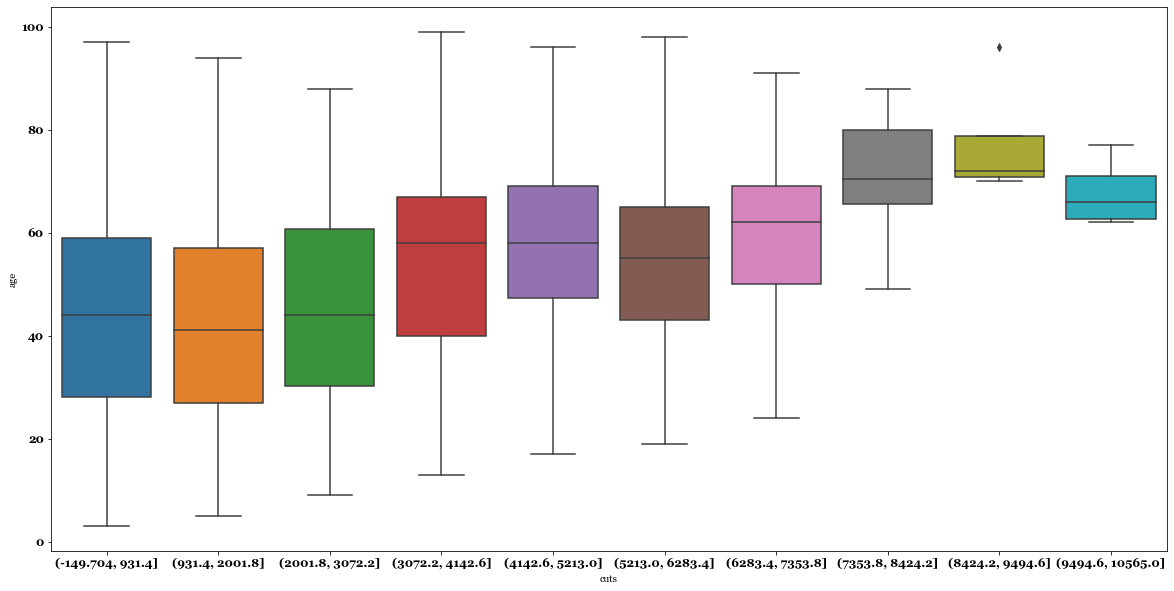

In [428]:
box = sns.boxplot(x=test['cuts'], y=test['age'])

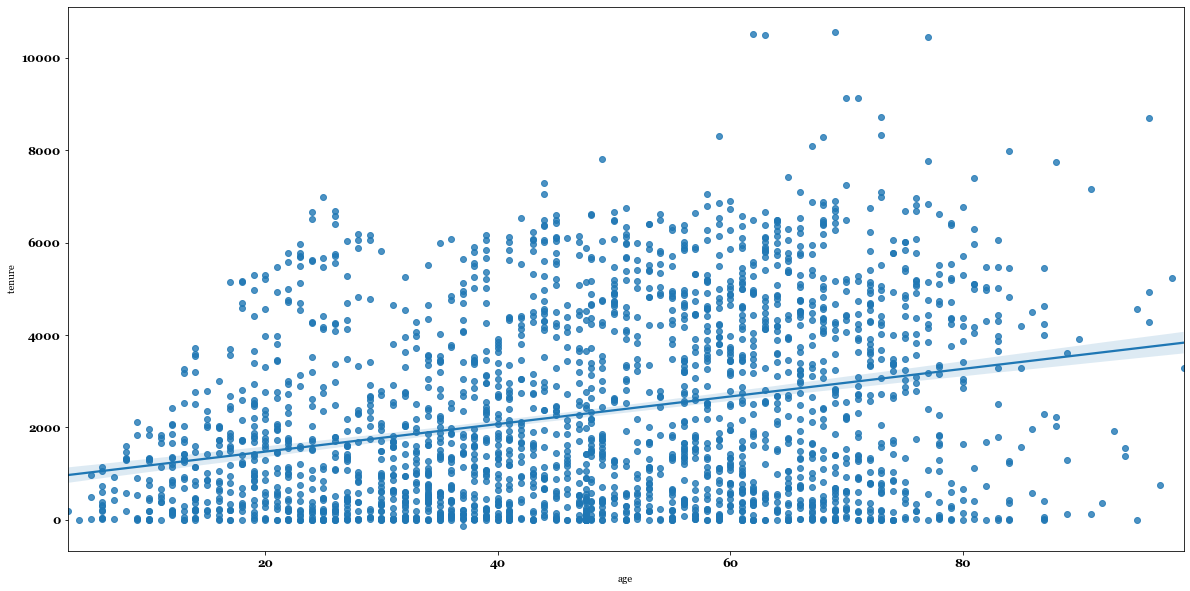

In [429]:
scat = sns.regplot(x=test.age, y=test.tenure)

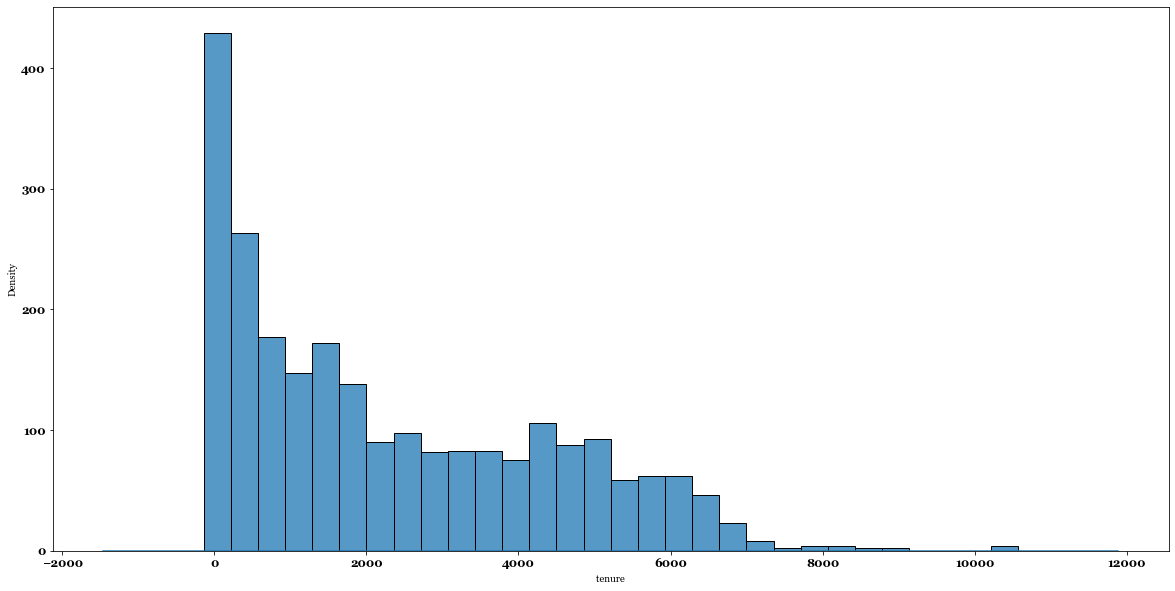

In [438]:
sns.kdeplot(test.tenure)
sns.histplot(pat.tenure, bins=30)

In [441]:
pat.rename(columns={'AptDate':'LastVisit'}, inplace=True)

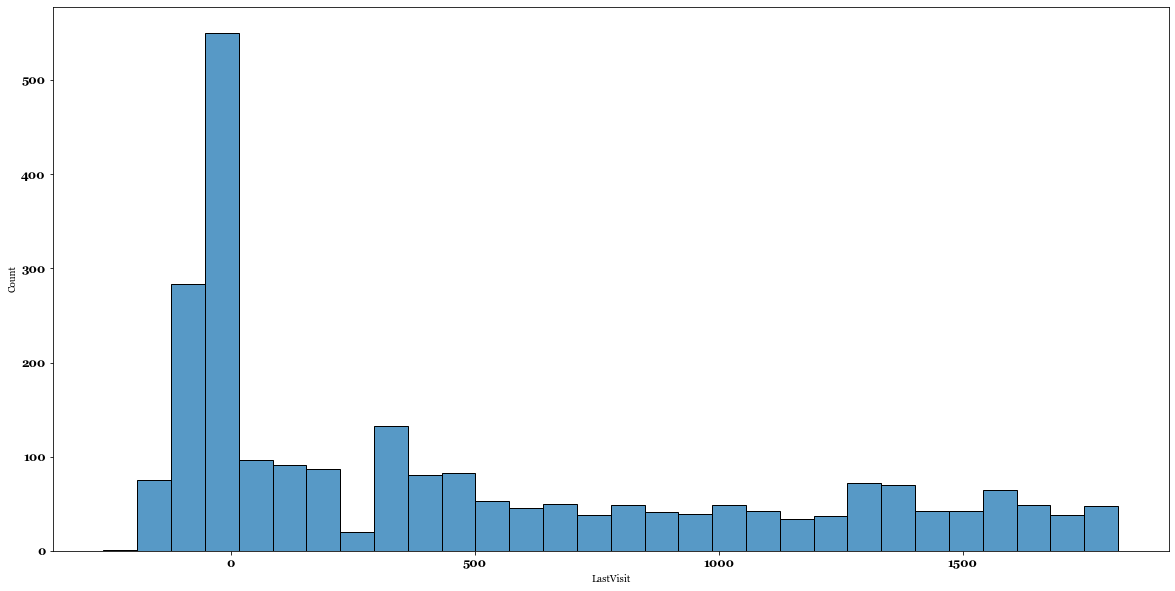

In [448]:
sns.histplot(((now - pat['LastVisit']).dt.days), bins=30)

In [449]:
churn = (now - pat['LastVisit']).dt.days

In [452]:
churn.name = 'churn'

In [454]:
pat = pd.concat([pat, churn], axis=1)

In [457]:
pd.Series(np.where(pat['churn'] < 400, 0, 1)).value_counts()

0    1372
1    1030
dtype: int64

In [458]:
lv = pat['LastVisit']

In [459]:
pat.drop('LastVisit', axis=1, inplace=True)

In [460]:
pat.rename(columns={'churn':'LastVisit'}, inplace=True)

In [462]:
pat['churn'] = np.where(pat['LastVisit'] < 400, 0, 1)

In [467]:
pat[pat['churn'] == 1]['LastVisit'].describe()

count    1030.000000
mean     1081.741748
std       428.852948
min       400.000000
25%       677.000000
50%      1084.000000
75%      1440.000000
max      1818.000000
Name: LastVisit, dtype: float64

In [496]:
freq = appt.groupby('PatNum')['AptDate'].count().to_frame().reset_index()

In [510]:
freq['AptDate'].name = 'num_visits'

In [490]:
pat = pat.sort_values('PatNum')

In [512]:
test = pat.merge(freq)

In [532]:
churn_zips = test[test['churn'] == 1]['Zip'].value_counts().head(10)
nonchurn_zips = test[test['churn'] == 0]['Zip'].value_counts().head(10)

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

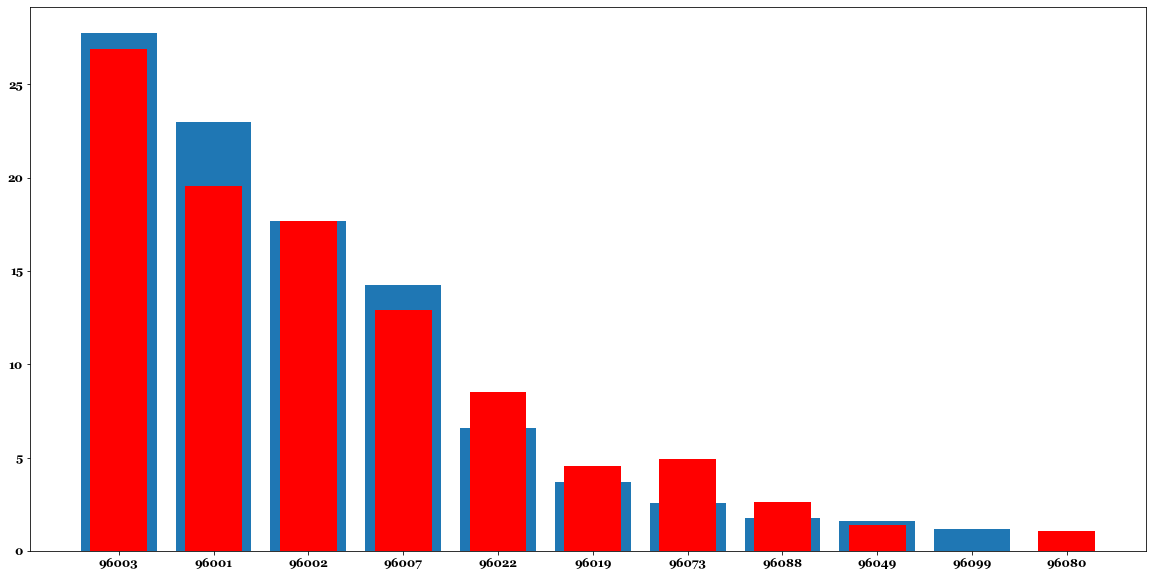

In [553]:
plt.bar(height=churn_zip_ratio.values, x=churn_zip_ratio.index)
plt.bar(height=nonchurn_zip_ratio.values, x = nonchurn_zip_ratio.index, width=0.6, color='red')

In [550]:
churn_zip_ratio = churn_zips/sum(churn_zips)*100

In [551]:
nonchurn_zip_ratio = nonchurn_zips/sum(nonchurn_zips) * 100

In [561]:
pat = test

In [562]:
pat.rename(columns={"AptDate":'num_visits'}, inplace=True)

In [564]:
pat.drop('DateFirstVisit', axis=1, inplace=True)

In [565]:
good_zips = ['96001', '96022', '96073', '96099', '96080']

In [566]:
def ufunc(row):
    if row in good_zips:
        return row
    else:
        return np.nan

In [570]:
pat.Zip = pat.Zip.apply(ufunc)

In [574]:
pat = pd.get_dummies(pat, columns=['Zip'])

In [588]:
pat

,PatNum,PatStatus,Gender,530_AreaCode,EstBalance,Bal_0_30,Bal_31_60,Bal_61_90,BalOver90,InsEst,BalTotal,HasIns,age,child,tenure,LastVisit,churn,num_visits,Zip_96001,Zip_96022,Zip_96073,Zip_96080,Zip_96099
0,3,1,0,1,185.0,0.0,0.0,185.0,0.0,135.0,1.850000e+02,1,62.000000,0,10511,-91,0,16,1,0,0,0,0
1,25,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1,63.000000,0,10494,-77,0,16,0,0,0,0,0
2,38,1,1,1,-6119.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,69.000000,0,10565,-148,0,12,0,0,0,0,0
3,46,1,0,1,-1806.1,0.0,0.0,0.0,0.0,0.0,-7.275958e-12,1,73.000000,0,8323,-97,0,19,0,0,0,0,0
4,69,1,0,1,-298.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1,77.000000,0,10444,-28,0,19,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,8544,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1,25.000000,0,0,-8,0,1,0,0,0,0,0
2398,8546,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,22.000000,0,0,-6,0,1,0,0,0,0,0
2399,8547,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,47.630565,0,441,-27,0,1,0,0,0,0,0
2400,8548,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0,47.630565,0,1064,-2,0,1,0,0,0,0,0


In [655]:
appt.groupby('ProvNum')['AptNum'].count()

ProvNum
1     6379
2     2846
3        3
4        5
5       20
6     1816
7     1162
8       10
9        2
10    4136
12     288
13     120
14      31
15    2482
16       1
19      45
Name: AptNum, dtype: int64

In [601]:
appt['PatNum'].nunique()

2402

In [603]:
appt[appt['ProvNum'] == 1]['PatNum'].nunique()

1708

In [604]:
for x in [1, 10, 2, 15, 6, 7]:
    value = appt[appt['ProvNum'] == x]['PatNum']

1708
1408
1225
1020
859
673


In [607]:
provider_dict = {k:(appt[appt['ProvNum'] == k]['PatNum']).unique() for k in [1,10,2,15,6,7]}

In [610]:
for x in provider_dict.values():
    print(len(x))

1708
1408
1225
1020
859
673


In [626]:
pat['seen_by_1'] =  np.where(pat['PatNum'].isin(provider_dict[1]), 1, 0)
pat['seen_by_10'] =  np.where(pat['PatNum'].isin(provider_dict[10]), 1, 0)
pat['seen_by_2'] =  np.where(pat['PatNum'].isin(provider_dict[2]), 1, 0)
pat['seen_by_15'] =  np.where(pat['PatNum'].isin(provider_dict[15]), 1, 0)
pat['seen_by_6'] =  np.where(pat['PatNum'].isin(provider_dict[6]), 1, 0)
pat['seen_by_7'] =  np.where(pat['PatNum'].isin(provider_dict[7]), 1, 0)

In [632]:
pat[pat['churn'] == 1].loc[:,'seen_by_1':'seen_by_7'].describe()

,seen_by_1,seen_by_10,seen_by_2,seen_by_15,seen_by_6,seen_by_7
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.679612,0.288350,0.502913,0.164078,0.300971,0.147573
std,0.466853,0.453215,0.500234,0.370526,0.458903,0.354848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [633]:
pat[pat['churn'] == 0].loc[:,'seen_by_1':'seen_by_7'].describe()

,seen_by_1,seen_by_10,seen_by_2,seen_by_15,seen_by_6,seen_by_7
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.734694,0.809767,0.515306,0.620262,0.400146,0.379738
std,0.441657,0.392628,0.499948,0.485498,0.490106,0.485498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [660]:
seen_cols = pat.loc[:, 'seen_by_1':].columns.tolist()

In [682]:
def churn_rate(df, cols):
    churn_dict = {}
    for col in cols:
        total = sum(df[col])
        non_churn = df[df['churn']==0][col].sum()
        churn = df[df['churn']==1][col].sum()
        rate = round(churn/total, 2)
        churn_dict[col] = (total, churn, non_churn, rate)
    return churn_dict

In [683]:
test = churn_rate(pat, seen_cols)
pd.DataFrame().from_dict(test, orient='index', columns=['Total Seen', 'churned', 'non_churned', 'churn_rate']).sort_values('churn_rate', ascending=False)

,Total Seen,churned,non_churned,churn_rate
seen_by_2,1225,518,707,0.42
seen_by_1,1708,700,1008,0.41
seen_by_6,859,310,549,0.36
seen_by_7,673,152,521,0.23
seen_by_10,1408,297,1111,0.21
seen_by_15,1020,169,851,0.17


In [692]:
churn_rate_through_2016 = pat.churn.sum()/len(pat)
print(f'Churn Rate over 2016-2020 Time Period: {round(churn_rate_through_2016, 2)*100}%')

Churn Rate over 2016-2020 Time Period: 43.0%
